[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/15_missing_data_and_other_opportunities.ipynb)

# Chapter 15 - Missing Data and Other Opportunities


## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz
    
USE_NIGHTLY_TFP = True # @param
if IN_COLAB and USE_NIGHTLY_TFP:
    !pip install --upgrade tf-nightly
    !pip install --upgrade tfp-nightly

In [2]:
%load_ext watermark

In [3]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.2
tensorflow 2.2.0-dev20200417
tensorflow_probability 0.11.0-dev20200417
arviz 0.7.0
scipy 1.4.1
pandas 1.0.3


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [6]:
if not USE_NIGHTLY_TFP:
    assert tf.__version__ >= '2.1.0', "Tensorflow version should be at minimum 2.1.0"
    assert tfp.__version__ >= '0.9.0', "TFP version should be at minimum 0.9.0"

## Tensorflow MCMC Sampling helpers

In [7]:
USE_XLA = False

In [8]:
NUMBER_OF_CHAINS  = 2
NUMBER_OF_BURNIN  = 500
NUMBER_OF_SAMPLES = 500
NUMBER_OF_LEAPFROG_STEPS = 4

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: np.swapaxes(v.numpy(), 1, 0)
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_chain(init_state,
              bijectors, 
              step_size, 
              target_log_prob_fn, 
              num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
              num_samples=NUMBER_OF_SAMPLES,
              burnin=NUMBER_OF_BURNIN,
              ):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn,
                    num_leapfrog_steps=num_leapfrog_steps,
                    step_size=step_size)         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors)       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat

def sample_posterior(jdc, 
                      observed_data, 
                      params, 
                      num_chains=NUMBER_OF_CHAINS,
                      init_state=None, 
                      bijectors=None,                              
                      num_samples=NUMBER_OF_SAMPLES, 
                      burnin=NUMBER_OF_BURNIN):       
    
    if init_state is None:
        init_state = list(jdc.sample(NUMBER_OF_CHAINS)[:-1])
        
    if bijectors is None:
        bijectors = [tfb.Identity() for i in init_state]


    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)    
    step_size = 0.1
    results, sample_stats = run_chain(init_state,
                                  bijectors,
                                  step_size=step_size,
                                  target_log_prob_fn=target_log_prob_fn,                                      
                                  num_samples=num_samples, 
                                  burnin=burnin)

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))    
    posterior = dict(zip(params, results))
    return _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

## Dataset URLs


In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/ksachdeva/rethinking-tensorflow-probability/master/data"

WAFFLE_DIVORCE_DATASET_PATH = f"{_BASE_URL}/WaffleDivorce.csv"

## Code 15.1

In [10]:
# simulate a pancake and return randomly ordered sides
def sim_pancake():
    pancake = tfd.Categorical(logits=np.ones(3)).sample().numpy()
    sides = np.array([1, 1, 1, 0, 0, 0]).reshape(3, 2).T[:, pancake]
    np.random.shuffle(sides)
    return sides

# sim 10,000 pancakes
pancakes = []
for i in range(10_000):
    pancakes.append(sim_pancake())
    
pancakes = np.array(pancakes).T

up = pancakes[0]
down = pancakes[1]

# compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 = np.sum(up == 1)
num_11 = np.sum((up == 1) & (down == 1))
num_11 / num_11_10

0.6659379968203497

## Code 15.2

In the waffle dataset, both divorce rate and marriage rate variables are measured with substantial error and that error is reported in the form of standard errors.

Also error varies across the states. 

Below we are plotting the measurement errors

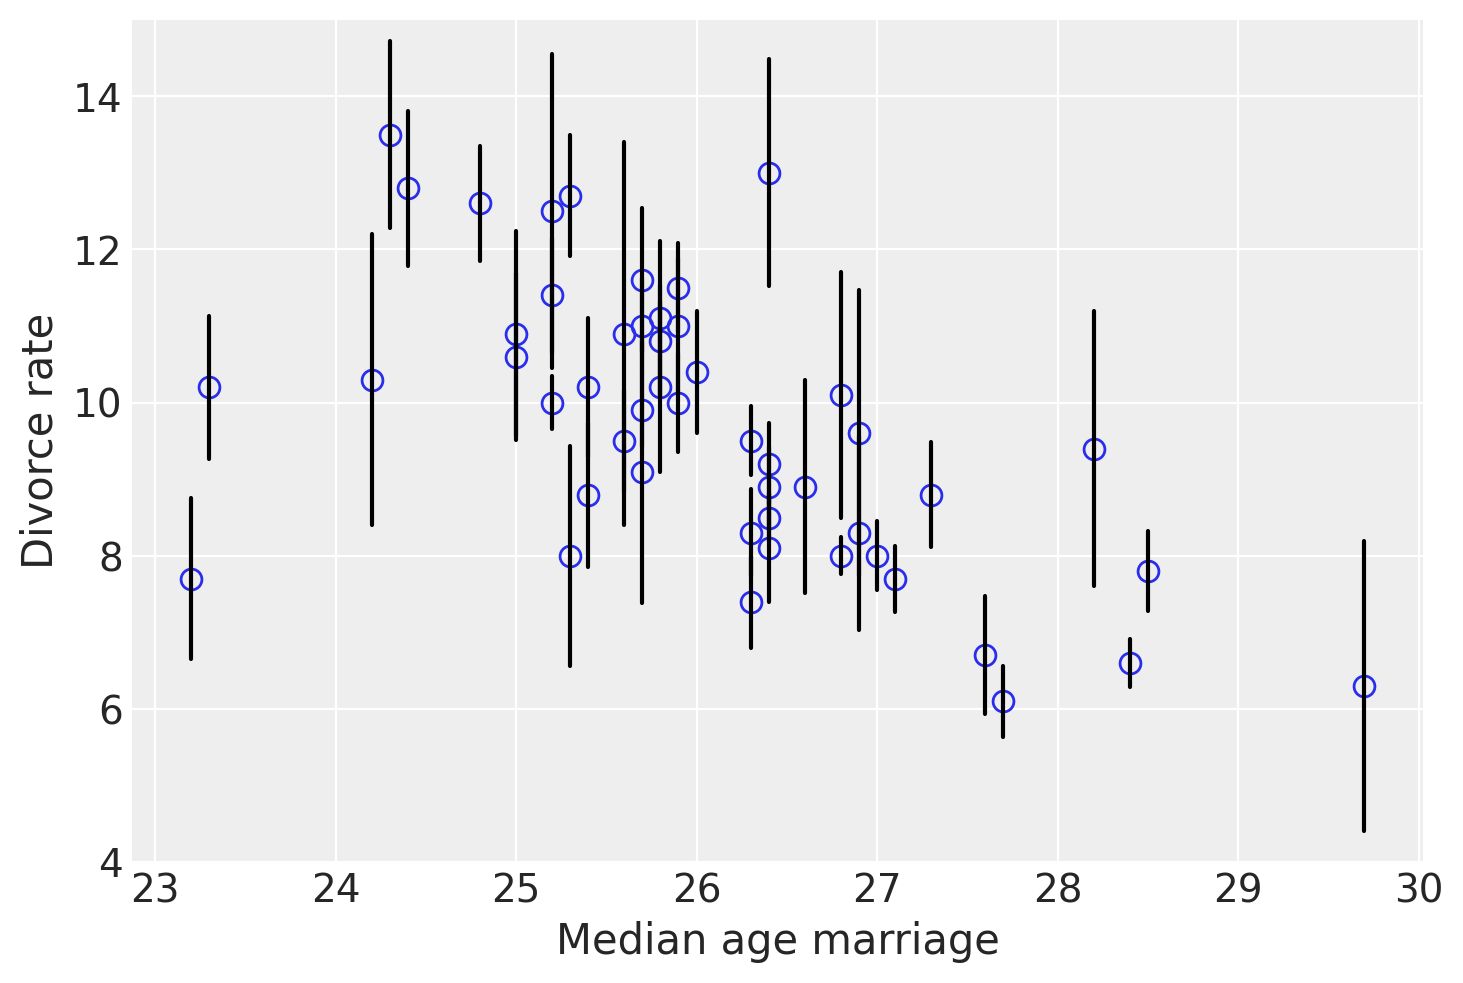

In [11]:
d = pd.read_csv(WAFFLE_DIVORCE_DATASET_PATH, sep=";")

# points
ax = az.plot_pair(d[["MedianAgeMarriage", "Divorce"]].to_dict(orient="list"),
                  plot_kwargs=dict(ms=15, mfc="none"))
ax.set(ylim=(4, 15), xlabel="Median age marriage", ylabel="Divorce rate")

# standard errors
for i in range(d.shape[0]):
    ci = d.Divorce[i] + np.array([-1, 1]) * d["Divorce SE"][i]
    x = d.MedianAgeMarriage[i]
    plt.plot([x, x], ci, "k")
    
    

In the above plot, the lenght of the vertical lines show how uncertain the observed divorce rate is.

## Code 15.3

In [12]:
dat = dict(
    D_obs=tf.cast(d.Divorce.pipe(lambda x: (x - x.mean()) / x.std()).values, dtype=tf.float32),
    D_sd=tf.cast(d["Divorce SE"].values / d.Divorce.std(), dtype=tf.float32),
    M=d.Marriage.pipe(lambda x: (x - x.mean()) / x.std()).values,
    A=d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std()).values,
    N=d.shape[0])


def model_15_1(A, M, D_sd, N):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaA"), sample_shape=1))
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))  
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      mu = alpha[...,tf.newaxis] + betaA[...,tf.newaxis] * A + betaM[...,tf.newaxis] * M    
    
      scale = sigma[...,tf.newaxis]
     
      D_true = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)    
      D_obs = yield tfd.Independent(tfd.Normal(loc=D_true, scale=D_sd), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_15_1 = model_15_1(dat["A"], dat["M"], dat["D_sd"], dat["N"])


In [13]:
NUM_CHAINS_FOR_15_1 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_15_1]),
    tf.zeros([NUM_CHAINS_FOR_15_1]),
    tf.zeros([NUM_CHAINS_FOR_15_1]),
    tf.ones([NUM_CHAINS_FOR_15_1]),
    tf.zeros([NUM_CHAINS_FOR_15_1, dat["N"]]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),
    tfb.Identity()
]

trace_15_1 = sample_posterior(jdc_15_1,
                               observed_data=(dat["D_obs"],),
                               params=['alpha', 'betaA', 'betaM', 'sigma', 'D_true'],
                               init_state=init_state,
                               bijectors=bijectors)

## Code 15.4

In [14]:
az.summary(trace_15_1, round_to=2, kind='all', credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.06,0.09,-0.18,0.09,0.01,0.01,144.37,144.37,142.88,154.96,1.01
betaA,-0.60,0.15,-0.88,-0.39,0.01,0.01,136.73,130.53,140.60,166.96,1.01
betaM,0.05,0.16,-0.20,0.27,0.02,0.01,86.60,86.60,92.48,68.14,1.02
sigma,0.57,0.10,0.43,0.75,0.01,0.01,61.93,61.93,58.72,30.46,1.05
D_true[0],1.16,0.36,0.69,1.86,0.03,0.02,121.21,121.21,121.37,129.09,1.00
D_true[1],0.73,0.47,-0.10,1.36,0.05,0.04,90.85,87.00,91.05,170.24,1.03
D_true[2],0.40,0.32,-0.10,0.91,0.02,0.02,178.65,175.54,181.49,255.42,1.02
D_true[3],1.37,0.43,0.70,2.06,0.04,0.03,118.15,118.15,119.48,121.18,1.00
D_true[4],-0.90,0.12,-1.09,-0.70,0.01,0.00,349.29,349.29,369.01,64.88,1.04
D_true[5],0.63,0.42,0.00,1.33,0.04,0.03,102.90,102.90,102.18,73.44,1.05


## Code 15.5

What happens when there is a measurement error on predictor variables as well ?

In [15]:
dat = dict(
    D_obs=tf.cast(d.Divorce.pipe(lambda x: (x - x.mean()) / x.std()).values, dtype=tf.float32),
    D_sd=tf.cast(d["Divorce SE"].values / d.Divorce.std(), dtype=tf.float32),
    M_obs=tf.cast(d.Marriage.pipe(lambda x: (x - x.mean()) / x.std()).values, dtype=tf.float32),
    M_sd=tf.cast(d["Marriage SE"].values / d.Marriage.std(), dtype=tf.float32),
    A=d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std()).values,
    N=d.shape[0])

def model_15_2(A, M_sd, D_sd, N):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaA"), sample_shape=1))
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))  
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))        
      M_true = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="M_true"), sample_shape=N))        
        
      mu = alpha[...,tf.newaxis] + betaA[...,tf.newaxis] * A + betaM[...,tf.newaxis] * M_true    
    
      scale = sigma[...,tf.newaxis]
     
      D_true = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)    
      D_obs = yield tfd.Independent(tfd.Normal(loc=D_true, scale=D_sd), reinterpreted_batch_ndims=1)
      M_obs = yield tfd.Independent(tfd.Normal(loc=M_true, scale=M_sd, name="M_obs"), reinterpreted_batch_ndims=1)    
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_15_2 = model_15_2(dat["A"], dat["M_sd"], dat["D_sd"], dat["N"])


In [16]:
NUM_CHAINS_FOR_15_2 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_15_2]),
    tf.zeros([NUM_CHAINS_FOR_15_2]),
    tf.zeros([NUM_CHAINS_FOR_15_2]),
    tf.ones([NUM_CHAINS_FOR_15_2]),
    tf.zeros([NUM_CHAINS_FOR_15_2, dat["N"]]),  # M_True
    tf.zeros([NUM_CHAINS_FOR_15_2, dat["N"]]),  # D_True
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity()
]

trace_15_2 = sample_posterior(jdc_15_2,
                               observed_data=(dat["D_obs"], dat["M_obs"]),                                   
                               params=['alpha', 'betaA', 'betaM', 'sigma', 'M_true', 'D_true'],
                               init_state=init_state,
                               bijectors=bijectors)

## Code 15.6

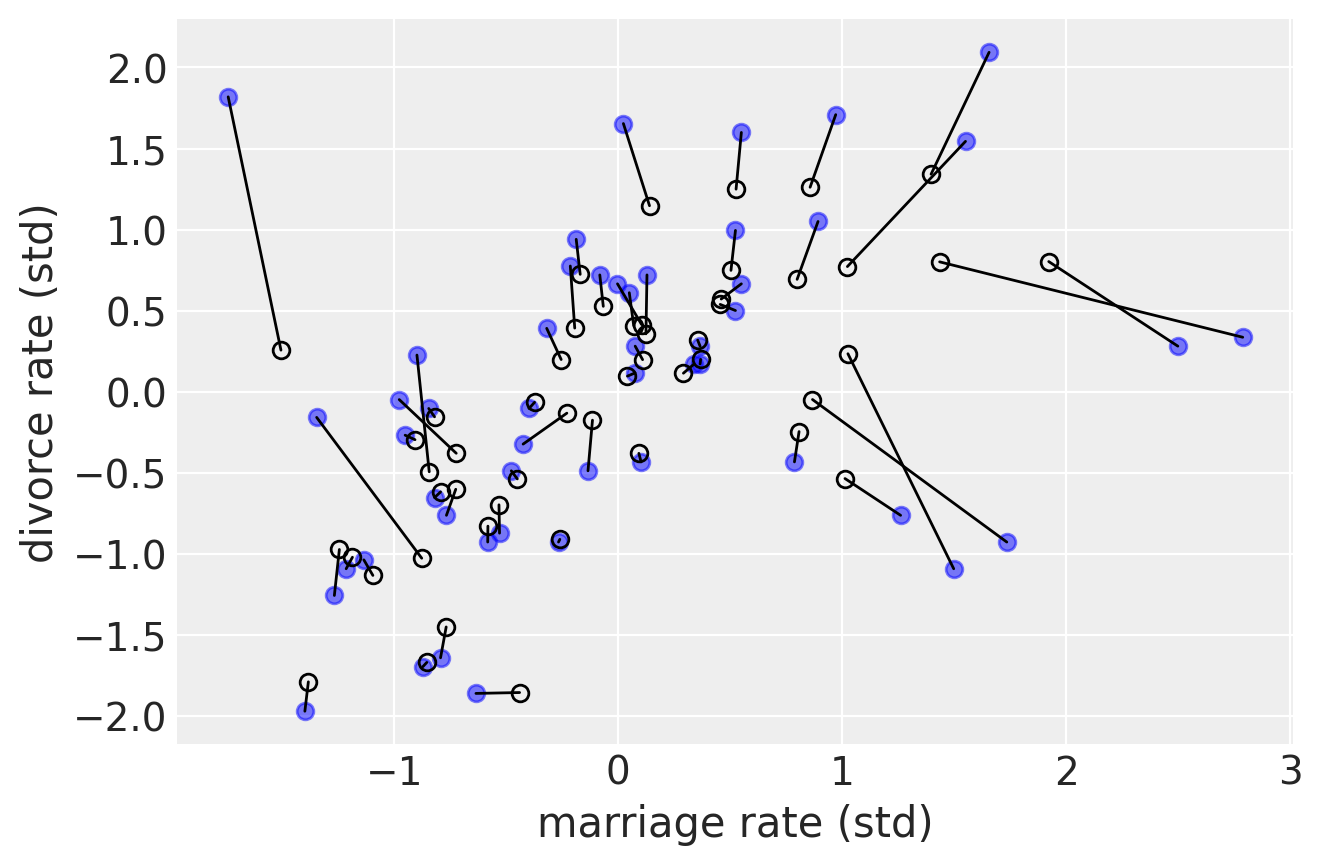

In [17]:
post_D_true = trace_15_2.posterior["D_true"].values[0]
post_M_true = trace_15_2.posterior["M_true"].values[0]

D_est = np.mean(post_D_true, 0)
M_est = np.mean(post_M_true, 0)
plt.plot(dat["M_obs"], dat["D_obs"], "bo", alpha=0.5)
plt.gca().set(xlabel="marriage rate (std)", ylabel="divorce rate (std)")
plt.plot(M_est, D_est, "ko", mfc="none")
for i in range(d.shape[0]):
    plt.plot([dat["M_obs"][i], M_est[i]], [dat["D_obs"][i], D_est[i]],
             "k-", lw=1)

Above figure demonstrates shrinkage of both divorce rate and marriage rate. Solid points are the observed values. Open points are posterior means. Lines connect pairs of points for the same state. Both variables are shrunk towards the inferred regression relationship.

With measurement error, the insight is to realize that any uncertain piece of data can be replaced by a distribution that reflects uncertainty.

## Code 15.7

In [18]:
# Simulated toy data

N = 500
A = tfd.Normal(loc=0., scale=1.0).sample((N,))
M = tfd.Normal(loc=-A, scale=1.0).sample()
D = tfd.Normal(loc=A, scale=1.0).sample()
A_obs = tfd.Normal(loc=A, scale=1.).sample()

## Code 15.8

In [19]:
N = 100
S = tfd.Normal(loc=0., scale=1.).sample((N,))
H = tfd.Binomial(total_count=10, probs=tf.sigmoid(S)).sample()

## Code 15.9

Hm = Homework missing

Dog's decision to eat a piece of homework or not is not influenced by any relevant variable

In [20]:
D = tfd.Bernoulli(0.5).sample().numpy()  # dogs completely random
Hm = np.where(D == 1, np.nan, H)

Hm

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

Since missing values are random, missignness does not necessiarily change the overall distribution of homework score.

## Code 15.10

Here studying influences whether a dog eats homework S->D

Students who study a lot do not play with their Dogs and then dogs take revenge by eating homework


In [21]:
D = np.where(S > 0, 1, 0)
Hm = np.where(D == 1, np.nan, H)

Hm

array([ 4., nan,  1.,  5.,  0.,  1.,  5., nan,  4., nan,  4.,  3.,  7.,
        0.,  5., nan,  3., nan,  1., nan,  2., nan,  3.,  2., nan, nan,
       nan, nan, nan,  4., nan,  2.,  5.,  1.,  3., nan,  0.,  5., nan,
        4.,  6.,  2., nan,  6., nan, nan, nan, nan, nan,  2., nan, nan,
        1., nan, nan,  4., nan, nan, nan,  3., nan, nan, nan,  5., nan,
        3., nan, nan,  2., nan,  0., nan,  4.,  4.,  6.,  6., nan, nan,
       nan,  3.,  5., nan,  6.,  2., nan,  2., nan, nan, nan,  4.,  2.,
        6.,  5.,  3.,  3.,  1.,  4.,  6., nan,  5.], dtype=float32)

Now every student who studies more than average (0) is missing homework

## Code 15.11

The case of noisy home and its influence on homework & Dog's behavior

In [22]:
# TODO - use seed; have not been able to make it work with tfp

N = 1000
X = tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=(N,)).sample().numpy()
S = tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=(N,)).sample().numpy()

logits = 2 + S - 2 * X

H = tfd.Binomial(total_count=10, logits=logits).sample().numpy()

D = np.where(X > 1, 1, 0)
Hm = np.where(D == 1, np.nan, H)

## Code 15.12

In [23]:
dat = dict(H=H, S=S)

def model_15_3(S):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="alpha"), sample_shape=1))
      betaS = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaS"), sample_shape=1))
              
      logits = tf.squeeze(alpha[...,tf.newaxis] + betaS[...,tf.newaxis] * S)      
      
      H = yield tfd.Independent(tfd.Binomial(total_count=10, logits=logits), reinterpreted_batch_ndims=1)    
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_15_3 = model_15_3(dat["S"])

In [24]:
NUM_CHAINS_FOR_15_3 = 4

alpha_init, betaS_init, _ = jdc_15_3.sample()

init_state = [
    tf.tile(alpha_init, (NUM_CHAINS_FOR_15_3,)),
    tf.tile(betaS_init, (NUM_CHAINS_FOR_15_3,))    
]


bijectors = [
    tfb.Identity(),
    tfb.Identity(),    
]

trace_15_3 = sample_posterior(jdc_15_3,
                               observed_data=(dat["H"],),                                     
                               params=['alpha', 'betaS'],
                               init_state=init_state,
                               bijectors=bijectors)

In [25]:
az.summary(trace_15_3, round_to=2, kind='all', credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.28,0.03,1.24,1.32,0.0,0.0,139.14,134.61,142.29,331.95,1.03
betaS,0.74,0.03,0.70,0.79,0.0,0.0,230.00,228.75,232.32,400.80,1.02


The true coefficient on S should be 1.00. We don’t expect to get that exactly, but the estimate above is way off

## Code 15.13

We build the model with missing data now

In [26]:
dat = dict(H=H[D==0], S=S[D==0])

def model_15_4(S):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="alpha"), sample_shape=1))
      betaS = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaS"), sample_shape=1))
              
      logits = tf.squeeze(alpha[...,tf.newaxis] + betaS[...,tf.newaxis] * S)      
      
      H = yield tfd.Independent(tfd.Binomial(total_count=10, logits=logits), reinterpreted_batch_ndims=1)    
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_15_4 = model_15_4(dat["S"])

In [27]:
NUM_CHAINS_FOR_15_4 = 2

alpha_init, betaS_init, _ = jdc_15_4.sample()

init_state = [
    tf.tile(alpha_init, (NUM_CHAINS_FOR_15_4,)),
    tf.tile(betaS_init, (NUM_CHAINS_FOR_15_4,))    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),    
]

trace_15_4 = sample_posterior(jdc_15_4,
                           observed_data=(dat["H"],),                                     
                           params=['alpha', 'betaS'],
                           init_state=init_state,
                           bijectors=bijectors)

In [28]:
az.summary(trace_15_4, round_to=2, kind='all', credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.92,0.03,1.87,1.97,0.0,0.0,673.50,671.72,679.83,404.77,1.0
betaS,0.92,0.03,0.86,0.97,0.0,0.0,933.05,909.66,900.39,452.94,1.0


## Code 15.14

In [29]:
D = np.where(np.abs(X) < 1, 1, 0)

## Code 15.15

In [30]:
N = 100
S = tfd.Normal(loc=0., scale=1.).sample((N,))
H = tfd.Binomial(total_count=10, logits=S).sample().numpy()
D = np.where(H < 5, 1, 0)
Hm = np.where(D == 1, np.nan, H)

Hm

array([ 7., nan,  7., nan,  9.,  8.,  5.,  6., nan, nan, nan, nan, nan,
        6.,  6., 10.,  5.,  5., nan,  7., nan, nan,  7.,  6.,  6.,  5.,
        6.,  5., nan,  7.,  5., nan,  8.,  8., nan,  8., nan,  5., nan,
        9.,  6., nan,  9., nan,  8., nan, nan, nan, nan, 10.,  6.,  5.,
        8.,  8., nan,  8., 10., nan, nan,  5., nan,  7.,  5., nan,  5.,
       nan,  7.,  6., nan,  6., nan,  7.,  6.,  7.,  8., nan,  8., nan,
       nan, nan,  9.,  5.,  6.,  5., nan, nan, nan,  5.,  5.,  8.,  7.,
       nan,  9., nan,  5.,  5.,  5.,  6.,  8.,  9.], dtype=float32)